# House Pricing Prediction

#### Problem Statement


A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

    Which variables are significant in predicting the price of a house, and

    How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

 

#### Business Goal 

 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [1]:
# Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

### Read and Understand Data

In [2]:
data = pd.read_csv('train.csv')

In [3]:
updateMissingCol=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']

In [4]:
for col in updateMissingCol:
    data[col].fillna(value='None',inplace=True)

 Missing value imputation to be done only for below columns.
['MasVnrArea', 'MasVnrType', 'Electrical','LotFrontage','GarageYrBlt']

In [5]:
data['Electrical'].fillna(value=data['Electrical'].mode()[0],inplace=True)

In [6]:
data['MasVnrType'].fillna(value=data['MasVnrType'].mode()[0],inplace=True)

In [7]:
data['MasVnrArea'].fillna(value=data['MasVnrArea'].median(),inplace=True)

In [8]:
data['LotFrontage'].fillna(value=data['LotFrontage'].median(),inplace=True)

GarageYrBlt missing values means absense of Garage. As in coming steps we are going to calculate age (derived column) 
and drop the original GarageBuilt column we will impute now it as YearSold+1. So that the age column will come as -1.

In [9]:
data['GarageYrBlt'].fillna(value=data['YrSold'],inplace=True)

Columns which have over 85% same value, wont contribute to the model hence can be dropped.

In [10]:
for col in data.columns:
    if round(data[col].value_counts(normalize=True).max(),2) > 0.85 :
        print("Removing Column : " + col + " with percentage : " + str(round(data[col].value_counts(normalize=True).max(),2)*100))
        data = data.drop(col,axis=1)

Removing Column : Street with percentage : 100.0
Removing Column : Alley with percentage : 94.0
Removing Column : LandContour with percentage : 90.0
Removing Column : Utilities with percentage : 100.0
Removing Column : LandSlope with percentage : 95.0
Removing Column : Condition1 with percentage : 86.0
Removing Column : Condition2 with percentage : 99.0
Removing Column : RoofMatl with percentage : 98.0
Removing Column : ExterCond with percentage : 88.0
Removing Column : BsmtCond with percentage : 90.0
Removing Column : BsmtFinType2 with percentage : 86.0
Removing Column : BsmtFinSF2 with percentage : 89.0
Removing Column : Heating with percentage : 98.0
Removing Column : CentralAir with percentage : 93.0
Removing Column : Electrical with percentage : 91.0
Removing Column : LowQualFinSF with percentage : 98.0
Removing Column : BsmtHalfBath with percentage : 94.0
Removing Column : KitchenAbvGr with percentage : 95.0
Removing Column : Functional with percentage : 93.0
Removing Column : Ga

In [11]:
# Id column has all unique values hence can be dropped.
data = data.drop('Id',axis=1)

### Derived Columns

Converting the Year columns(YearBuilt, YearRemodAdd, GarageYrBlt to Age(as per sold year) and drop the original 3 year columns.

In [12]:
data['Age_Built_Sold']=data['YrSold']-data['YearBuilt']
data['Age_ReBuilt_Sold']=data['YrSold']-data['YearRemodAdd']
data['Age_Garage_Sold']=(data['YrSold']-data['GarageYrBlt']).astype(int)

In [13]:
data = data.drop('GarageYrBlt',axis=1)
data = data.drop('YearBuilt',axis=1)
data = data.drop('YearRemodAdd',axis=1)

In [14]:
data['YrSold']=data['YrSold'].astype('object')

### Convert number values into logical categories for EDA.

[MSSubClass,OverallQual,OverallCond,MoSold]

In [15]:
data['OverallQual'] = data['OverallQual'].map({1:'VPoor',2:'Poor', 3:'Fair',4:'BelAvg',5:'Avg',6:'AbvAvg',7:'Good',8:'VGood',9:'Exc',10:'VExc'})
data['OverallCond'] = data['OverallCond'].map({1:'VPoor',2:'Poor',3:'Fair',4:'BelAvg',5:'Avg',6:'AbvAvg',7:'Good',8:'VGood',9:'Exc',10:'VExc'})

In [16]:
data['MSSubClass'] = data['MSSubClass'].map({20:'1-STORY 1946 & NEWER',30:'1-STORY 1945 & OLDER',40:'1-STORY W/FINISHED ATTIC',45:'1-1/2 STORY-UNFINISHED',50:'1-1/2 STORY FINISHED',60:'2-STORY 1946 & NEWER',70:'2-STORY 1945 & OLDER',75:'2-1/2 STORY',80:'SPLIT OR MULTI-LEVEL',85:'SPLIT FOYER',90:'DUPLEX',120:'1-STORY PUD',150:'1-1/2 STORY PUD',160:'2-STORY PUD',180:'PUD-MULTILEVEL',190:'2 FAMILY CONVERSION'})

In [17]:
data['MoSold'] = data['MoSold'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

### Analysis of Target variable - SalePrice

In [18]:
target_col = ['SalePrice_log']
data['SalePrice_log'] = np.log(data['SalePrice'])
saleprice = data[['SalePrice']].copy()
data = data.drop('SalePrice',axis=1) # removing the orignal variable

### Split data to numerical and categorical data

In [19]:
num_col = data.select_dtypes(include=np.number).columns.tolist()
num_col

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'Age_Built_Sold',
 'Age_ReBuilt_Sold',
 'Age_Garage_Sold',
 'SalePrice_log']

In [20]:
cat_col = list(set(data.columns)-set(num_col))
cat_col

['Neighborhood',
 'OverallCond',
 'HouseStyle',
 'LotConfig',
 'Foundation',
 'LotShape',
 'HeatingQC',
 'RoofStyle',
 'BldgType',
 'Exterior1st',
 'BsmtFinType1',
 'MSSubClass',
 'MSZoning',
 'FireplaceQu',
 'MasVnrType',
 'YrSold',
 'Exterior2nd',
 'BsmtQual',
 'Fence',
 'KitchenQual',
 'GarageFinish',
 'MoSold',
 'BsmtExposure',
 'OverallQual',
 'ExterQual',
 'GarageType',
 'SaleCondition']

In [21]:
for col in cat_col:
    data[col]=data[col].astype('object')

### Outlier Treatment for numeric columns

In [22]:
def outlier_treatment(df,colName):
    IQR = df[colName].quantile(0.75)-df[colName].quantile(0.25)
    UF = df[colName].quantile(0.75) + (1.5*IQR)
    df.loc[df[colName] > UF,colName]=UF

In [23]:
for col in num_col:
    outlier_treatment(data,col)

#### Separation of features for Label Encoding and One Hot Encoding

Label Encoding can be done for below columns

In [24]:
labelEncCol = [
'OverallQual',
'OverallCond',
'LotShape',
'ExterQual',
'BsmtQual',
'BsmtExposure',
'BsmtFinType1',
'HeatingQC',
'KitchenQual',
'FireplaceQu',
'GarageFinish']

### Creating Label Encoding

In [25]:
data['OverallQual'] = data['OverallQual'].map({'VPoor':0,'Poor':1,'Fair':2,'BelAvg':3,'Avg':4,'AbvAvg':5,'Good':6,'VGood':7,'Exc':8,'VExc':9})
data['OverallCond'] = data['OverallCond'].map({'VPoor':0,'Poor':1,'Fair':2,'BelAvg':3,'Avg':4,'AbvAvg':5,'Good':6,'VGood':7,'Exc':8,'VExc':9})

data['LotShape'] = data['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}) #3 indicates better i.e. Regular LotShape
data['ExterQual'] = data['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })

data['BsmtQual'] = data['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['BsmtExposure'] = data['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
data['BsmtFinType1'] = data['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
data['HeatingQC'] = data['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})

data['KitchenQual'] = data['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['FireplaceQu'] = data['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['GarageFinish'] = data['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })

One Hot Encoding can be done for below columns

In [26]:
dummy_col = list(set(cat_col)-set(labelEncCol))
dummy_col

['RoofStyle',
 'BldgType',
 'Exterior1st',
 'Fence',
 'YrSold',
 'MSSubClass',
 'Neighborhood',
 'HouseStyle',
 'MasVnrType',
 'Exterior2nd',
 'MSZoning',
 'LotConfig',
 'MoSold',
 'Foundation',
 'GarageType',
 'SaleCondition']

### One Hot Encoding Or Creating dummy variables

In [27]:
data = pd.get_dummies(data=data,columns=dummy_col,drop_first=True)

In [28]:
scaleCols = num_col+labelEncCol
scaleCols

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'Age_Built_Sold',
 'Age_ReBuilt_Sold',
 'Age_Garage_Sold',
 'SalePrice_log',
 'OverallQual',
 'OverallCond',
 'LotShape',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish']

### Train Test Split

In [29]:
df_train, df_test = train_test_split(data, train_size=.7, random_state=100)

### Scaling of Data - MinMaxScaler

In [30]:
scaler = MinMaxScaler()
df_train[scaleCols] = scaler.fit_transform(df_train[scaleCols])
df_test[scaleCols] = scaler.transform(df_test[scaleCols])

In [31]:
y_train=df_train.pop('SalePrice_log')
X_train=df_train
y_test=df_test.pop('SalePrice_log')
X_test=df_test

### Custom Functions

In [32]:
def PlotHistErrorTerms(y,y_pred):
    sns.set_style('white')
    plt.figure(figsize=(5,5), dpi=100)
    res1 = (y - y_pred)     #residuals
    sns.distplot(res1 , bins = 30, color='g')
    plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
    plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
    plt.grid(True)
    plt.show()

In [33]:
def ScatterPlotActPred(y,y_pred):
    sns.set_style('white')
    plt.figure(figsize = (8,6))
    plt.scatter(y,y_pred)
    plt.title('y_actual vs y_pred', fontweight='bold', fontsize = 20)           
    plt.xlabel('y_actual', fontstyle='italic', fontsize = 16)              
    plt.ylabel('y_pred', fontstyle='italic', fontsize = 16) 
    plt.grid(True)
    plt.show()

In [34]:
def PlotActualPredicted(y,y_pred,obsCount):
    sns.set_style('white')
    plt.figure(figsize = (8,4), dpi=120)
    f1 = [i for i in range(0,obsCount,1)]
    g1 = [i for i in range(0,obsCount,1)]
    plt.plot(f1, y_pred, color="blue", linewidth=1, linestyle="-")     
    plt.plot(g1, y, color="red",  linewidth=1, linestyle="-")  
    plt.title("Actual and Predicted", fontsize=15, fontweight='bold')    
    plt.xlabel('Index', fontsize=15, fontstyle='italic')                              
    plt.ylabel('SalePrice', fontsize=15, fontstyle='italic')  
    plt.show()

In [35]:
def PlotErroTermSpread(y,y_pred,obsCount):
    sns.set_style('white')
    plt.figure(figsize = (6,4), dpi=100)
    j1 = [i for i in range(0,obsCount,1)] 
    res_train1 = (y_train-y_pred_train_l)
    plt.scatter(j1, res_train1)

    plt.title('Error Terms', fontsize=18, fontweight='bold')              
    plt.xlabel('Index', fontstyle='italic', fontsize=14)                      
    plt.ylabel('y_actual - y_pred', fontstyle='italic', fontsize=14)   
    plt.grid(True)
    plt.show()

In [36]:
def predictions(y,y_pred):
    ##R2 score
    r2score = round(r2_score(y_true= y, y_pred= y_pred),4)
    
    ##Check the mean squared error (MSE)
    MSE = round(mean_squared_error(y, y_pred),4)
    
    ##Mean Absolute error for train and test sets
    MAE = round(mean_absolute_error(y, y_pred),4)

    ##Root Mean Squared Error for Train and Test Sets
    RMSE = round(np.sqrt(MAE),4)
    print("\nR2 score:",r2score,"\nMSE score:",MSE,"\nMAE score:",MAE,"\nRMSE score:",RMSE)



In [37]:
def createDataFrameModelCoeff(coef):
    df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':coef.round(4), \
                         'Abs_Coefficient(Desc_Sort)':abs(coef.round(4))})
    ##Sorting coefficient in descending order of absolute values and reset index
    df = df.sort_values(by='Abs_Coefficient(Desc_Sort)', ascending=False)
    df.reset_index(drop=True, inplace=True)  
    return df

In [38]:
def PlotCoeffTop10(df):
    top10_df= df.loc[:9] #Lasso_df with top 10 coefficients

    sns.set(style='white')
    plt.figure(figsize=(16,8), dpi=120)
    ax4= sns.barplot(y=top10_df['Features'], x=top10_df['Coefficient'], palette='Set1')

    plt.xlabel('Coefficient Values', fontsize= 14, fontstyle='italic')
    plt.ylabel('Features' , fontsize= 14, fontstyle='italic')
    plt.title('Coefficents of Top 10 Features : ', fontsize=18,fontweight='bold')

    c= top10_df['Coefficient'] #Storing coefficient values
    for index, value in enumerate(c):
        plt.text(value, index, str(value), fontsize=13)

    plt.grid(True)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.autoscale()
    plt.tight_layout()
    plt.show() 

### Lasso Regression Model

In [39]:
folds = 5
lasso = Lasso()

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [40]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [41]:
#Fitting Ridge model for best alpha and printing coefficients which have been penalised

alpha_lasso1 =0.0001

lasso1 = Lasso(alpha=alpha_lasso1)
        
lasso1.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [42]:
y_pred_train_lasso1 = lasso1.predict(X_train)
y_pred_test_lasso1 = lasso1.predict(X_test)

In [43]:
print("For Lasso Regression Model (Original Model: alpha=" + str(alpha_lasso1) +"):\n","*"*55)
print("\nFor Train Set:")
predictions(y_train,y_pred_train_lasso1)
print("\nFor Test Set:")
predictions(y_test,y_pred_test_lasso1)

For Lasso Regression Model (Original Model: alpha=0.0001):
 *******************************************************

For Train Set:

R2 score: 0.9304 
MSE score: 0.0016 
MAE score: 0.0281 
RMSE score: 0.1676

For Test Set:

R2 score: 0.8929 
MSE score: 0.0026 
MAE score: 0.0337 
RMSE score: 0.1836


In [44]:
lasso1_df = createDataFrameModelCoeff(lasso1.coef_)
lasso1_df.head(10)

,Features,Coefficient,Abs_Coefficient(Desc_Sort)
0,GrLivArea,0.2352,0.2352
1,OverallQual,0.1544,0.1544
2,OverallCond,0.1275,0.1275
3,MSZoning_FV,0.0810,0.0810
4,TotalBsmtSF,0.0808,0.0808
5,Age_Built_Sold,-0.0778,0.0778
6,MSZoning_RL,0.0776,0.0776
7,MSZoning_RH,0.0753,0.0753
8,MSZoning_RM,0.0589,0.0589
9,LotArea,0.0456,0.0456


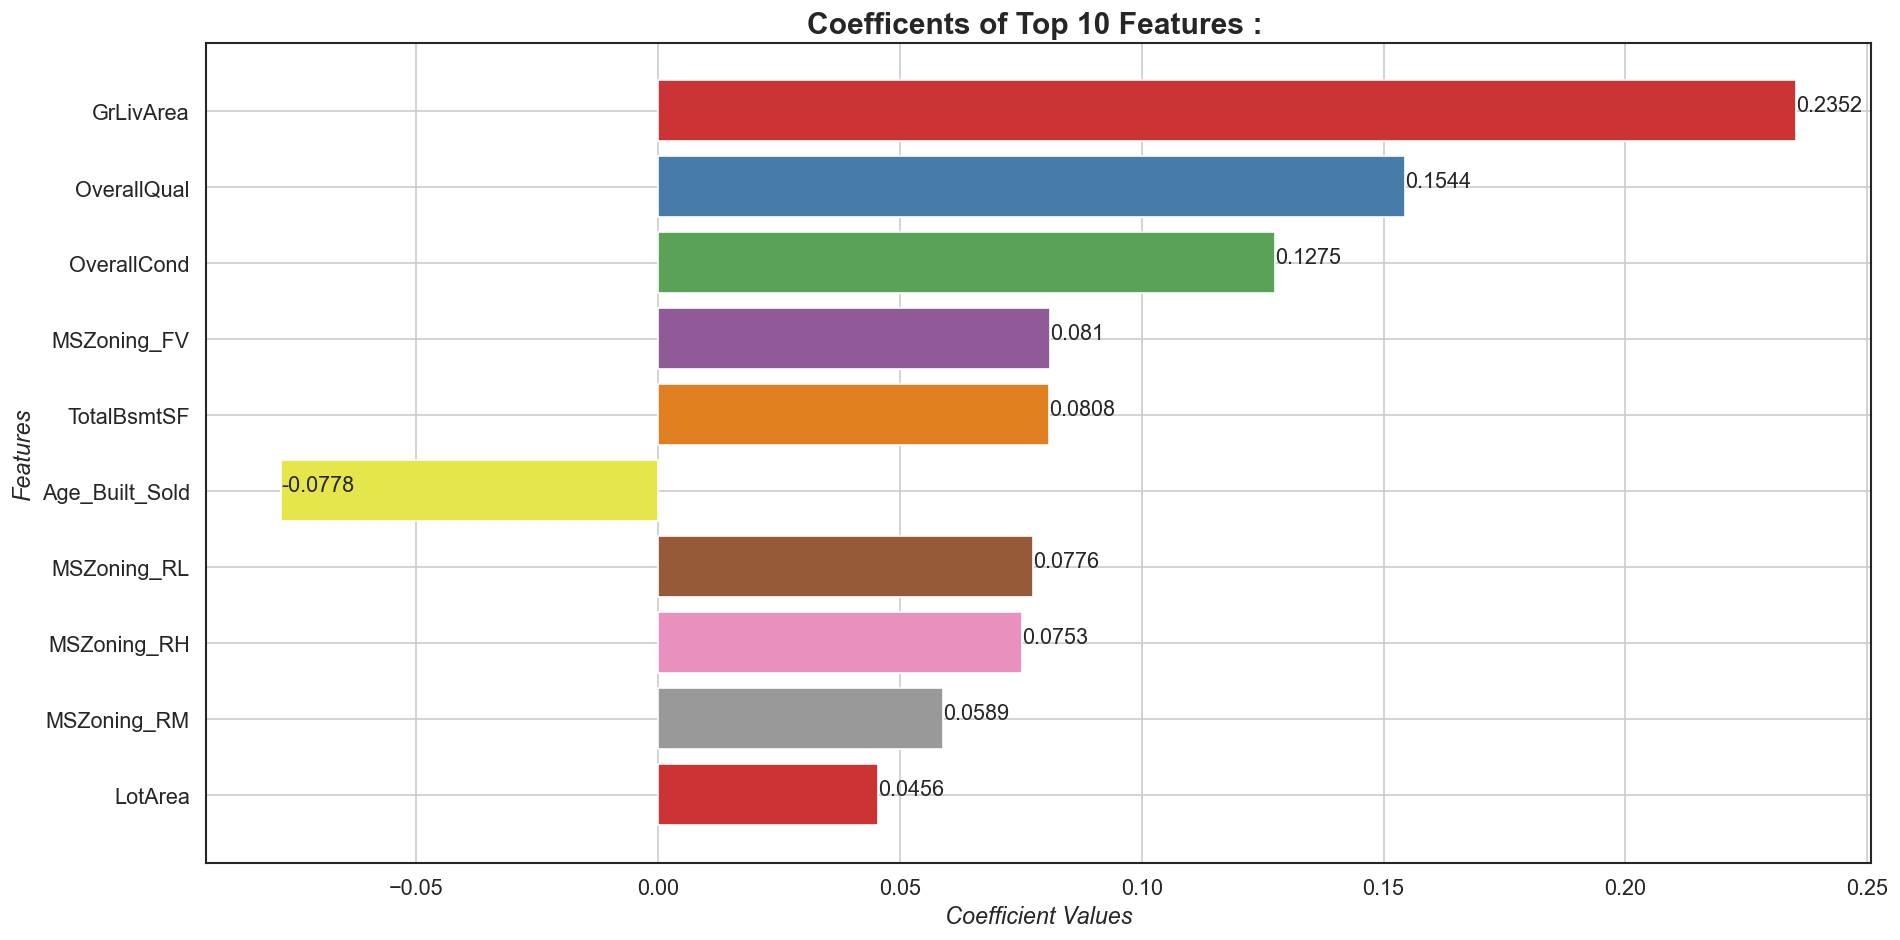

In [45]:
PlotCoeffTop10(lasso1_df)

In [46]:
#finalFeatures = list(lasso1_df.head(10)['Features'])
finalFeatures = ['GrLivArea',
 'OverallQual',
 'OverallCond',
 'TotalBsmtSF',
 'Age_Built_Sold',
]
finalFeatures

['GrLivArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'Age_Built_Sold']

In [47]:
X_train = X_train[finalFeatures]
X_test = X_test[finalFeatures]

In [48]:
alpha_lasso1 =0.0001
finalModel = Lasso(alpha=alpha_lasso1)    
finalModel.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [49]:
y_pred_train_final = finalModel.predict(X_train)
y_pred_test_final = finalModel.predict(X_test)

In [50]:
print("Final Model : \n","*"*10)
print("\nFor Train Set:")
predictions(y_train,y_pred_train_final)
print("\nFor Test Set:")
predictions(y_test,y_pred_test_final)

Final Model : 
 **********

For Train Set:

R2 score: 0.8563 
MSE score: 0.0033 
MAE score: 0.0412 
RMSE score: 0.203

For Test Set:

R2 score: 0.8493 
MSE score: 0.0037 
MAE score: 0.0429 
RMSE score: 0.2071


In [53]:
# Save the model
import joblib 

# Save the model as a pickle in a file 
joblib.dump(finalModel, 'models/hp_model.pkl') 

['models/hp_model.pkl']

In [54]:
X_train.head()

,GrLivArea,OverallQual,OverallCond,TotalBsmtSF,Age_Built_Sold
318,0.955999,0.666667,0.500,0.656433,0.130081
239,0.454186,0.555556,0.375,0.358187,0.528455
986,0.518266,0.555556,0.875,0.236355,0.780488
1416,0.801862,0.333333,0.625,0.378655,1.000000
390,0.402230,0.444444,0.875,0.419591,0.878049


In [55]:
X_test.head()

,GrLivArea,OverallQual,OverallCond,TotalBsmtSF,Age_Built_Sold
1436,0.184446,0.333333,0.625,0.421053,0.292683
57,0.555068,0.666667,0.500,0.419103,0.016260
780,0.352871,0.666667,0.500,0.602827,0.097561
382,0.588407,0.666667,0.500,0.457602,0.008130
1170,0.294420,0.555556,0.625,0.534113,0.252033


In [56]:
y_pred_test_final[0]

0.4584238913706992

In [57]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439 entries, 1436 to 210
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GrLivArea       439 non-null    float64
 1   OverallQual     439 non-null    float64
 2   OverallCond     439 non-null    float64
 3   TotalBsmtSF     439 non-null    float64
 4   Age_Built_Sold  439 non-null    float64
dtypes: float64(5)
memory usage: 20.6 KB


In [58]:
int_features = ['0.184446', '0.333333', '0.625', '0.421053', '0.292683']
final_features = pd.DataFrame([np.array(int_features)])
final_features

,0,1,2,3,4
0,0.184446,0.333333,0.625,0.421053,0.292683


In [59]:
finalModel.predict(X_test.head(1))

array([0.45842389])

In [60]:
import sklearn
print(sklearn.__version__)

1.0.2


In [61]:
import numpy
numpy.version.version

'1.21.5'